# NeRF: Neural Radiance Field

## Import

In [1]:
import os

import matplotlib.pyplot as plt
import nerf.infer
import nerf.train
import numpy as np
import torch
import torch.jit as jit

from ipywidgets import widgets
from moviepy.editor import ImageSequenceClip
from nerf.data import BlenderDataset
from nerf.core import NeRF
from nerf.core import BoundedVolumeRaymarcher as BVR
from nerfcfg import RenderConfig, TrainConfig
from PIL import Image
from torch.cuda.amp import GradScaler
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm.auto import tqdm

torch.backends.cudnn.benchmark = True
%matplotlib inline

## Train

### Setup

In [2]:
tcfg = TrainConfig()
tcfg.display()

In [3]:
print(tcfg)

TrainConfig:
    # Dataset
    self.blender = './data/blender'
    self.scene ='hotdog'
    self.step = 1
    self.scale = 0.1
    
    # Model
    self.features = 256
    self.sigma = 26.0
    self.width = 128
    self.depth = 2
    
    # Bounded Volume Raymarcher
    self.tn = 2.0, self.tf = 6.0
    self.samples = 64
    self.perturb = True
    
    # Hyperparameters
    self.epochs = 100
    self.log = 10
    self.lr = 0.005
    self.fp16 = True
    self.batch_size = 16384
    self.jobs = 0

    # Paths
    self.model_ts = './res/NeRF_hotdog.ts'
    self.gt_png = './res/NeRF_hotdog_gt.png'
    self.pred_png = './res/NeRF_hotdog_pred.png'
        


### Data

In [4]:
train = BlenderDataset(tcfg.blender, tcfg.scene, "train", step=tcfg.step, scale=tcfg.step)
val = BlenderDataset(tcfg.blender, tcfg.scene, "val", step=tcfg.step, scale=tcfg.step)
test = BlenderDataset(tcfg.blender, tcfg.scene, "test", step=tcfg.step, scale=tcfg.step)

[BlenderDataset(hotdog, train)] Loading Data:   0%|          | 0/100 [00:00<?, ?it/s]

[BlenderDataset(hotdog, train)] Building Rays:   0%|          | 0/100 [00:00<?, ?it/s]

[BlenderDataset(hotdog, val)] Loading Data:   0%|          | 0/100 [00:00<?, ?it/s]

[BlenderDataset(hotdog, val)] Building Rays:   0%|          | 0/100 [00:00<?, ?it/s]

[BlenderDataset(hotdog, test)] Loading Data:   0%|          | 0/200 [00:00<?, ?it/s]

[BlenderDataset(hotdog, test)] Building Rays:   0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
W, H = val.W, val.H
vro, vrd = val.turnaround_data()
vro, vrd = vro[:W * H], vrd[:W * H]

[BlenderDataset(hotdog, val)] Building Rays:   0%|          | 0/40 [00:00<?, ?it/s]

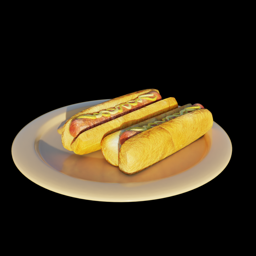

In [6]:
gt = val.C[:W * H].view(W, H, 3).clip(0, 1) * 255
gt = gt.numpy().astype(np.uint8)

img = Image.fromarray(gt)
img.save(tcfg.gt_png)
display(img.resize((256, 256)))

### Model

In [7]:
features, sigma = (tcfg.features, tcfg.features), (tcfg.sigma, tcfg.sigma)
nerf = NeRF(*features, *sigma, width=tcfg.width, depth=tcfg.depth).cuda()
raymarcher = BVR(tcfg.tn, tcfg.tf, samples=tcfg.samples)

### Optimization

In [8]:
criterion = MSELoss().cuda()
optim = Adam(nerf.parameters(), lr=tcfg.lr)
scaler = GradScaler(enabled=tcfg.fp16)

### Callbacks

In [9]:
w_gt = widgets.Image(value=b"", format="png", width=256, height=256)
w_pred = widgets.Image(value=b"", format="png", width=256, height=256)

with open(tcfg.gt_png, "rb") as f:
    w_gt.value = f.read()

In [10]:
do_callback = lambda e: (e % (tcfg.log - 1) == 0) or (e == (tcfg.epochs - 1))


def save_callback(epoch: int) -> None:
    if do_callback(epoch):
        print(f"[NeRF] Saving Model's Weights to `{tcfg.model_ts}`")
        jit.save(jit.script(nerf), tcfg.model_ts)

        
def render_callback(epoch: int) -> None:
    if do_callback(epoch):
        pred = nerf.infer(raymarcher, vro, vrd, W, H, batch_size=tcfg.batch_size)
        pred = pred.numpy().astype(np.uint8)
        
        img = Image.fromarray(pred)
        img.save(tcfg.pred_png)
      
    
def update_pred(epoch: int) -> None:
    if do_callback(epoch):
        with open(tcfg.pred_png, "rb") as f:
            w_pred.value = f.read()

            
callbacks = [save_callback, render_callback, update_pred]

### Fit

In [11]:
display(widgets.HBox([w_gt, w_pred]))

In [ ]:
history = nerf.fit(
    raymarcher,
    optim,
    criterion,
    scaler,
    train,
    epochs=tcfg.epochs,
    batch_size=tcfg.batch_size,
    jobs=tcfg.jobs,
    perturb=tcfg.perturb,
    callbacks=callbacks,
)

[NeRF] Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

[NeRF] Train:   0%|          | 0/3907 [00:00<?, ?it/s]

In [ ]:
if history:
    x = list(range(len(history.train)))
    
    plt.figure()
    plt.title("Train History")
    plt.subplots(1, 2, 1)
    plt.gca().set_title("MSE")
    plt.plot(x=x, y=[mse for mse, _ in history.train], label="train")
    plt.plot(x=x, y=[mse for mse, _ in history.val], label="val")
    plt.subplots(1, 2, 2)
    plt.gca().set_title("PSNR")
    plt.plot(x=x, y=[psnr for _, psnr in history.train], label="train")
    plt.plot(x=x, y=[psnr for _, psnr in history.val], label="val")
    
    print(f"Test MSE={history.test[0]} PSNR={history.test[1]}")

## Inference

### Setup

In [ ]:
rcfg = RenderConfig()
rcfg.display()

In [ ]:
print(rcfg)

### Data

In [ ]:
val = BlenderDataset(rcfg.blender, rcfg.scene, "val", step=rcfg.step, scale=rcfg.step)

In [ ]:
ros, rds = val.turnaround_data(samples=rcfg.frames)
W, H = val.W, val.H
S = W * H
n = len(ros)

### Model

In [ ]:
nerf = jit.load(rcfg.model_ts).cuda()
raymarcher = BVR(rcfg.tn, rcfg.tf, samples=rcfg.samples)

nerf.infer = lambda *args, **kwargs: NeRF.infer(nerf, *args, **kwargs)

### Inference

In [ ]:
preds = np.zeros((rcfg.frames, W, H, 3), dtype=np.uint8)
pbar = tqdm(range(0, n, S), desc="[NeRF] Frame")
for i, s in enumerate(pbar):
    ro, rd = ros[s:s + S], rds[s:s + S]
    pred = nerf.infer(raymarcher, ro, rd, W, H, batch_size=rcfg.batch_size, verbose=False)
    preds[i] = pred.numpy().astype(np.uint8)

In [ ]:
clip = ImageSequenceClip(list(preds), durations=[1. / rcfg.fps] * rcfg.frames)
clip.write_gif(rcfg.pred_gif, fps=rcfg.fps)

In [ ]:
w_gif = widgets.Image(value=b"", format="gif", width=256, height=256)

with open(rcfg.pred_gif, "rb") as f:
    w_gif.value = f.read()
    
display(w_gif)